In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import scipy
import pickle
import warnings
import bidict
import collections

import sys
sys.path.append('..')
from construct_graph.graph import Graph, Flat
import construct_graph
import solve_laplace_operator

import sparseqr

from IPython.display import display, HTML

display(HTML("""
<style>
.jp-OutputArea-output {max-width: 100% !important;}
.jp-Cell-outputWrapper {max-width: 100% !important;}
.jp-OutputArea-output pre {max-width: 100% !important;}
</style>
"""))

def calculate_pde_eigenvalues(m, n):
    a = 1 / 2
    return np.sqrt(((2 * np.pi * m)**2 + (2 * np.pi * n)**2) * a)

class Renormalization:

    def __init__(self, g, partition_type="by_tile", num_patches_per_dim=None, autoplot=True):

        self.g = g
        self.partition_type = partition_type

        if self.partition_type == "by_patch":
            self.num_patches_per_dim = num_patches_per_dim
            self.num_patches = self.num_patches_per_dim**2
            self.patch_side_length = 1.0 / self.num_patches_per_dim
        elif self.partition_type == "by_tile":
            self.num_patches = (self.g.num_horizontal_displacements 
                                * self.g.num_vertical_displacements)

        self.super_V_coords, self.patch_coords, self.V_to_super_V, self.translations = self.partition_graph()
        self.E_data = self.construct_E_data()

        if autoplot:
            self.plot_patching(figsize=5)

    def __call__(self, calculation="full"):

        if calculation == "full":

            alpha_x, alpha_y = self.solve_for_bilinear_coefficients()

            Q = [np.zeros((2, 2)) for _ in range(self.num_patches)]
            T = [0 for _ in range(self.num_patches)]

            for v, w in self.E_data:
                
                l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]
                alpha_v = np.array([alpha_x[v], alpha_y[v]])
                alpha_w = np.array([alpha_x[w], alpha_y[w]])
                fac = (r_ij + alpha_w - alpha_v)
                T[self.V_to_super_V[v]["patch_num"]] += l_vw
                Q[self.V_to_super_V[v]["patch_num"]] += fac[:, None] @ fac[None, :] / l_vw

        return Q, T
    
    def solve_for_bilinear_coefficients(self):

        C = scipy.sparse.lil_matrix((self.g.num_Vs + 1, self.g.num_Vs))
        Dx = np.zeros(self.g.num_Vs + 1)
        Dy = np.zeros(self.g.num_Vs + 1)
        
        for v, w in self.E_data:

            l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]

            C[v, w] -= 1 / l_vw
            C[v, v] += 1 / l_vw

            Dx[v] += r_ij[0] / l_vw
            Dy[v] += r_ij[1] / l_vw

        C[-1] = np.ones(self.g.num_Vs)
        C = scipy.sparse.csc_matrix(C)

        # alpha_x = scipy.sparse.linalg.lsqr(C, Dx)[0] 
        # alpha_y = scipy.sparse.linalg.lsqr(C, Dy)[0]
        alpha_x = sparseqr.solve(C, Dx)#, tolerance = 1e-9 )
        alpha_y = sparseqr.solve(C, Dy)#, tolerance = 1e-9 )

        return alpha_x, alpha_y

    def partition_graph(self):
        
        super_V_coords = []
        V_to_super_V = {}
        super_V_to_V = collections.defaultdict(list)
        patch_coords = []

        if self.partition_type == "by_tile":

            tile_num = -1
            for row in range(self.g.num_vertical_displacements):
                for col in range(self.g.num_horizontal_displacements):
                    tile_num += 1
                    v_indices = np.arange(tile_num * self.g.num_Vs_for_tile, (tile_num + 1) * self.g.num_Vs_for_tile)
                    tile = self.g.V_coords[v_indices]
                    super_V_coords.append(np.mean(tile, axis=0))
                    for v_index in v_indices:
                        V_to_super_V[v_index] = {"patch_num": tile_num, 
                                                 "patch_indices": np.array([col, row])}

            # Calculate x, y translations by looking at displacements between tiles
            max_displacement = np.max([self.g.horizontal_displacement, self.g.vertical_displacement])
            horizonal_displacement = (self.g.horizontal_displacement / max_displacement 
                                      / self.g.num_horizontal_displacements)
            vertical_displacement = (self.g.vertical_displacement / max_displacement 
                                     / self.g.num_vertical_displacements)

            translations = np.array([horizonal_displacement, vertical_displacement])

        elif self.partition_type == "by_patch": 

            # Create the patch_coords
            for row in range(self.num_patches_per_dim):
                for col in range(self.num_patches_per_dim):
                    center_x = (col + 0.5) * self.patch_side_length
                    center_y = (row + 0.5) * self.patch_side_length
                    patch_coords.append([center_x, center_y])
            patch_coords = np.array(patch_coords)

            # Assign each vertex to the corresponding patch
            for v_num, (x, y) in enumerate(self.g.V_coords):
                patch_col = np.floor(x / self.patch_side_length).astype(int)
                patch_row = np.floor(y / self.patch_side_length).astype(int)
                patch_num = patch_row * self.num_patches_per_dim + patch_col
                V_to_super_V[v_num] = {"patch_num": patch_num, 
                                       "patch_indices": np.array([patch_col, patch_row])}
                super_V_to_V[patch_num].append(v_num)
                
            # Create super_V_coords
            super_V_coords = []
            for patch_num in range(self.num_patches):
                if self.g.V_coords[super_V_to_V[patch_num]].size == 0:
                    super_V_coords.append(None)
                else:
                    super_V_coords.append(np.mean(self.g.V_coords[super_V_to_V[patch_num]], axis=0))
            # super_V_coords = np.array(super_V_coords)  

            self.super_V_to_V = super_V_to_V      

            translations = np.array([self.patch_side_length, self.patch_side_length])

        return super_V_coords, patch_coords, V_to_super_V, translations
    
    def construct_E_data(self):

        E_data = {}

        if self.partition_type == "by_tile":

            for v, w in zip(*self.g.wadjacency_matrix.nonzero()):
                E_data[v, w] = {"l_vw": self.g.wadjacency_matrix[v, w]}

                if (v, w) in self.g.periodic_edges or (w, v) in self.g.periodic_edges:
                    a, b = (v % self.g.num_Vs_for_tile), (w % self.g.num_Vs_for_tile) 

                    if (a, b) in self.g.connectivity_map: 
                        r_ij = np.array(self.g.directions[self.g.connectivity_map[a, b][0]['direction']])
                    else: 
                        r_ij = -np.array(self.g.directions[self.g.connectivity_map[b, a][0]['direction']])
                    r_ij = r_ij * self.translations
                else:
                    i, j = self.V_to_super_V[v]["patch_num"], self.V_to_super_V[w]["patch_num"]
                    r_ij = self.super_V_coords[j] - self.super_V_coords[i]

                E_data[v, w]["r_ij"] = r_ij

        elif self.partition_type == "by_patch":

            for v, w in zip(*self.g.wadjacency_matrix.nonzero()):
                E_data[v, w] = {"l_vw": self.g.wadjacency_matrix[v, w]}

                if (v, w) in self.g.periodic_edges or (w, v) in self.g.periodic_edges: 

                    i_index = self.V_to_super_V[v]["patch_indices"].copy()
                    j_index = self.V_to_super_V[w]["patch_indices"].copy()
                    ji_ind_dif = j_index - i_index
                    patch_i_coords = self.super_V_coords[self.V_to_super_V[v]["patch_num"]].copy()
                    patch_j_coords = self.super_V_coords[self.V_to_super_V[w]["patch_num"]].copy()

                    if ji_ind_dif[0] == self.num_patches_per_dim - 1:
                        patch_j_coords[0] -= 1
                    elif ji_ind_dif[0] == -(self.num_patches_per_dim - 1):
                        patch_j_coords[0] += 1
                    if ji_ind_dif[1] == self.num_patches_per_dim - 1:
                        patch_j_coords[1] -= 1
                    elif ji_ind_dif[1] == -(self.num_patches_per_dim - 1):
                        patch_j_coords[1] += 1

                    r_ij = patch_j_coords - patch_i_coords

                else:
                    i_num, j_num = self.V_to_super_V[v]["patch_num"], self.V_to_super_V[w]["patch_num"]
                    r_ij = self.super_V_coords[j_num] - self.super_V_coords[i_num]

                E_data[v, w]["r_ij"] = r_ij

        return E_data
    
    def plot_patching(self, figsize=10, linewidth=2,
                      return_figax=False, plot_V_nums=False):
        
        if self.partition_type == "by_tile":
            raise ValueError("Plotting for partitioning by tile not yet implemented")

        fig, ax = self.g.plot_graph(return_figax=True, figsize=figsize, linewidth=linewidth)
        for center in self.patch_coords:
            bottom_corner = (center[0] - self.patch_side_length / 2, center[1] - self.patch_side_length / 2)
            square = matplotlib.patches.Rectangle(bottom_corner, self.patch_side_length, self.patch_side_length,
                                                  linewidth=2 * linewidth, 
                                                  edgecolor='r', facecolor=(0.8, 0.8, 0.8, 0.1), alpha=1)
            ax.add_patch(square)
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)

        if plot_V_nums:
            for v_num, v_coord in enumerate(self.g.V_coords):
                ax.annotate(str(v_num), v_coord, fontsize=20)

        if return_figax:
            return fig, ax
        plt.show()

In [2]:
nums_Vs_for_tile = (10**np.linspace(1.7, 4, 30)).astype(int)
print(nums_Vs_for_tile)
num_seeds = 32
N = 1

[   50    60    72    86   104   124   149   179   216   259   311   373
   448   538   646   775   931  1117  1341  1610  1932  2320  2785  3343
  4012  4816  5781  6940  8330 10000]


In [3]:
full_Qs = {}

for num_Vs_for_tile in nums_Vs_for_tile:
    print(num_Vs_for_tile)
    Qs_for_num_Vs = []
    if num_Vs_for_tile < 5000:
        max_seed = 32
    else:
        max_seed = 8
    for seed in range(max_seed):
        np.random.seed(seed)
        print(seed)
        g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
                                            num_Vs_for_tile=num_Vs_for_tile,
                                            num_horizontal_displacements=N, 
                                            num_vertical_displacements=N,
                                            autoplot=False)
        R = Renormalization(g, "by_tile", autoplot=False)
        Q, T = R()
        Qs = []
        for i, j in zip(Q, T):
            if np.abs(j) > 1e-13:
                Qs.append(i / j)
        Qs_for_num_Vs.append(np.trace(Qs[0])**0.5)
    full_Qs[num_Vs_for_tile] = Qs_for_num_Vs.copy()
    print(full_Qs[num_Vs_for_tile])
    print()

50
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
[0.9704015998719933, 0.9692872555903742, 0.960788948614398, 0.9627836558105125, 0.9650175371903827, 0.9561765443259461, 0.9627001044798842, 0.9516670762452428, 0.9602130478086217, 0.9718087446253109, 0.9563514724912157, 0.9659841000615097, 0.9689112833033762, 0.9660410523316699, 0.964037420802273, 0.9657248706453482, 0.9684606844718202, 0.9615463535192976, 0.9668569138344598, 0.9679470129971101, 0.9595022066286819, 0.9666804731987882, 0.9720122501946228, 0.9753154913946902, 0.9675357183236899, 0.9538785956164315, 0.9670031607895393, 0.9657985555561778, 0.9631643859375042, 0.9618236097440771, 0.969813592027927, 0.9639178128742395]

60
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
[0.9564261038744857, 0.9667578352986499, 0.9564435639895731, 0.9601278690333676, 0.9657410594613969, 0.9528265638463602, 0.9591074264915421, 0.9653667636919532, 0.9626368996502044, 0.

In [4]:
full_eigs = {}

for num_Vs_for_tile in nums_Vs_for_tile:
    print(num_Vs_for_tile)
    eigs_for_num_Vs = []
    if num_Vs_for_tile < 5000:
        max_seed = 32
        guesses = np.linspace(3.6, 4.8, 50)
    else:
        max_seed = 8
        guesses = np.linspace(4.1, 4.4, 22)
    for seed in range(max_seed):
        np.random.seed(seed)
        print(seed)
        g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
                                            num_Vs_for_tile=num_Vs_for_tile,
                                            num_horizontal_displacements=N, 
                                            num_vertical_displacements=N,
                                            autoplot=False)
        eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
        ks = eigs(guesses, printerval=np.inf, max_steps=1000, tol=1e-12, solve_type="SVD iterate")
        _, index = np.unique(np.round(ks, 6), return_index=True)
        eigenvalues = ks[index]
        eigs_for_num_Vs.append(eigenvalues)
    full_eigs[num_Vs_for_tile] = eigs_for_num_Vs.copy()
    print(full_eigs[num_Vs_for_tile])
    print()

50
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
[array([3.88997714, 4.12486084, 4.27122877, 4.59874476]), array([3.83736609, 3.95834166, 4.4618325 , 4.58008755]), array([3.6346415 , 4.1177327 , 4.51220387, 4.56544502]), array([3.93427592, 4.12992223, 4.29121637, 4.42071117]), array([3.81251626, 3.99551452, 4.40577327, 4.700957  ]), array([-18.78702093,   3.83147222,   3.99253118,   4.33321466,
         4.42063146]), array([4.09656808, 4.17820852, 4.27313128, 4.3375053 ]), array([3.95764557, 3.98280796, 4.21287355, 4.45656529]), array([3.86536135, 4.07186677, 4.34633534, 4.52749557]), array([3.96960757, 4.13596972, 4.26550893, 4.48070494]), array([3.84693839, 4.15436871, 4.30255383, 4.41563078]), array([3.81407241, 4.19319104, 4.28078624, 4.56346168]), array([3.8524782 , 4.00717337, 4.33120363, 4.79083426]), array([3.75245287, 4.12978735, 4.28660136, 4.68869043]), array([3.7684437 , 4.14087828, 4.37098624, 4.53636939]), array([-4.04950251,  4.013

In [9]:
cleaned_full_data = {}
for num_Vs_for_tile in nums_Vs_for_tile:
    cleaned_full_data[num_Vs_for_tile] = [a[a>0][:4] for a in full_eigs[num_Vs_for_tile]]

In [12]:
pairs = []
for num_Vs_for_tile in nums_Vs_for_tile:
    a = cleaned_full_data[num_Vs_for_tile].copy()
    for en, b in enumerate(a):
        if len(b) != 4:
            pairs.append([num_Vs_for_tile, en])
            print(num_Vs_for_tile, en)
            print(b)
            print()

3343 25
[4.23206572 4.25830195 4.31198899]

4012 23
[4.21292538 4.24968569 4.29008712]

4012 31
[4.19964625 4.26159662 4.29616826]

4816 21
[4.20683458 4.25155143 4.29245356]



In [14]:
for num_Vs_for_tile, seed in pairs:
    print(seed)
    guesses = np.linspace(4, 4.8, 60)
    np.random.seed(seed)
    g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
                                        num_Vs_for_tile=num_Vs_for_tile,
                                        num_horizontal_displacements=N, 
                                        num_vertical_displacements=N,
                                        autoplot=False)
    eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
    ks = eigs(guesses, printerval=np.inf, max_steps=1000, tol=1e-12, solve_type="SVD iterate")
    _, index = np.unique(np.round(ks, 6), return_index=True)
    eigenvalues = ks[index]
    cleaned_full_data[num_Vs_for_tile][seed] = eigenvalues[eigenvalues > 0][:4]

25
23
31
21


In [26]:
np.mean(cleaned_full_data[num_Vs_for_tile]) / calculate_pde_eigenvalues(1, 0)

0.9586325760510617

In [95]:
file = open("/Users/sidneyholden/repos/metric_graph/data/tiling/random_delaunay_triangulation_periodic/eigenvalue_data.pkl", "rb")
loaded_data = pickle.load(file)
file.close()

In [43]:
means_Qs = []
means_eigs = []
std_Qs = []
std_eigs = []
for num_Vs_for_tile in nums_Vs_for_tile:
    
    data_Qs = full_Qs[num_Vs_for_tile]
    data_eigs = np.array(cleaned_full_data[num_Vs_for_tile]) / calculate_pde_eigenvalues(1, 0)

    means_Qs.append(np.mean(data_Qs))
    means_eigs.append(np.mean(data_eigs))

    std_Qs.append(np.std(data_Qs))
    std_eigs.append(np.std(data_eigs))

In [59]:
2 * np.pi / np.sqrt(2)

4.442882938158366

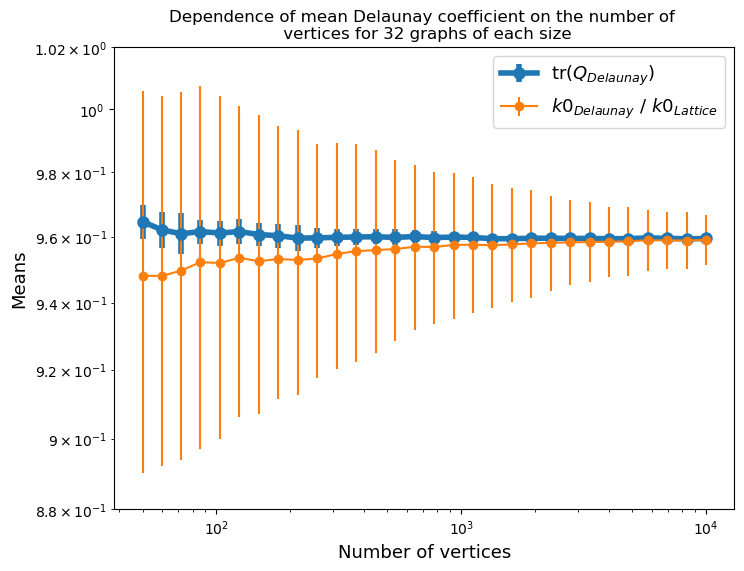

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# ax.loglog(nums_Vs_for_tile, means_Qs, 'o-')
# ax.loglog(nums_Vs_for_tile, means_eigs, 'o-')

ax.errorbar(nums_Vs_for_tile, means_Qs, yerr=std_Qs, fmt='o-', markersize=8, label='tr$(Q_{Delaunay})$', linewidth=4)
ax.errorbar(nums_Vs_for_tile, means_eigs, yerr=std_eigs, fmt='o-', label='$k0_{Delaunay} \ / \ k0_{Lattice}$')

# Set the scale to log-log
ax.set_xscale('log')
ax.set_yscale('log')

# Add labels and legend
ax.set_xlabel('Number of vertices', fontsize=13)
ax.set_ylabel('Means', fontsize=13)
ax.legend(fontsize=13)

# plt.xlim(5e0, 1.4e3)
plt.ylim(0.88, 1.02)
# plt.xlabel("Mean number of vertices per (uncoupled) patch", fontsize=12)
# plt.ylabel("Mean over (uncoupled) patches of trace($Q$)", fontsize=12)
# plt.plot([80, 1e4], [0.958865282483461, 0.958865282483461])
plt.title("Dependence of mean Delaunay coefficient on the number of \n vertices for 32 graphs of each size")
# plt.savefig("trQ.png", dpi=200, bbox_inches="tight")
plt.show()

In [36]:
def calculate_difs(a):
    b = []
    for i in range(len(a) - 1):
        b.append(np.abs(a[i] - a[i+1]))

    return b

In [37]:
cauchy_nums_Vs_for_tile = calculate_difs(nums_Vs_for_tile)
cauchy_means_Qs = calculate_difs(means_Qs)
cauchy_means_eigs = calculate_difs(means_eigs)

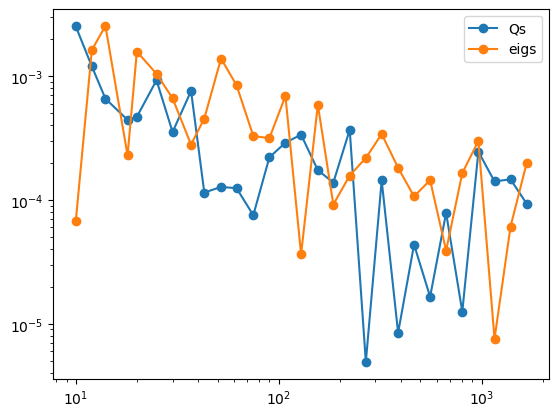

In [39]:
plt.loglog(cauchy_nums_Vs_for_tile, cauchy_means_Qs, 'o-', label="Qs")
plt.loglog(cauchy_nums_Vs_for_tile, cauchy_means_eigs, 'o-', label="eigs")
plt.legend()

# plt.xlim(5e0, 1.4e3)
# plt.ylim(0.952, 0.97)
# plt.xlabel("Mean number of vertices per (uncoupled) patch", fontsize=12)
# plt.ylabel("Mean over (uncoupled) patches of trace($Q$)", fontsize=12)
# plt.plot([80, 1e4], [0.958865282483461, 0.958865282483461])
# plt.title("Dependence of trace(Q) on the number of \n vertices per (uncoupled) patch for one 10k vertex graph")
# plt.savefig("trQ_by_patch_density3.png", dpi=200, bbox_inches="tight")
plt.show()

In [97]:
loaded_data[630]

{0: array([1.48283526e-15, 4.08754376e+00, 4.20089379e+00, 4.33631202e+00,
        4.44096178e+00, 5.84143334e+00, 5.93043665e+00, 6.08146226e+00,
        6.25417727e+00]),
 1: array([7.11608349e-16, 4.09601553e+00, 4.22977198e+00, 4.29620236e+00,
        4.41797894e+00, 5.83644160e+00, 5.99508986e+00, 6.08892416e+00,
        6.16899715e+00]),
 2: array([4.28437957e-15, 4.14258752e+00, 4.26079817e+00, 4.28257492e+00,
        4.35323951e+00, 5.73514171e+00, 6.04539686e+00, 6.15101656e+00,
        6.19636897e+00]),
 3: array([3.16451852e-16, 4.16735636e+00, 4.21937456e+00, 4.25946573e+00,
        4.31881251e+00, 5.84644499e+00, 5.93948294e+00, 6.01010413e+00,
        6.23246323e+00]),
 4: array([9.97885558e-16, 4.03423551e+00, 4.17637233e+00, 4.24955941e+00,
        4.41062729e+00, 5.75103575e+00, 5.91684157e+00, 6.10143516e+00,
        6.17700105e+00]),
 5: array([-3.54929009e-16,  4.18304819e+00,  4.21737049e+00,  4.23260453e+00,
         4.47497772e+00,  5.74929254e+00,  5.98045004e+0